EJERCICIO REGRESIONES

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Cargar el dataset
df = pd.read_excel("DATASET_MODIFICADO_SIN_FECHA_HORA.xlsx")

# ------------------- 1.1 Codificación ordinal de lesividad -------------------

lesividad_ordinal = {
    "Sin asistencia sanitaria": 0,
    "Asistencia sanitaria sólo en el lugar del accidente": 1,
    "Asistencia sanitaria inmediata en centro de salud o mutua": 2,
    "Asistencia sanitaria ambulatoria con posterioridad": 3,
    "Atención en urgencias sin posterior ingreso": 4,
    "Ingreso inferior o igual a 24 horas": 5,
    "Ingreso superior a 24 horas": 6,
    "Fallecido 24 horas": 7
}

df["lesividad"] = df["lesividad"].map(lesividad_ordinal)

# ------------------- 1.2 Codificación ordinal de variables independientes -------------------

tipo_accidente_ordinal = {
    "Alcance": 0, "Atropello a animal": 1, "Atropello a persona": 2, "Caída": 3,
    "Choque contra obstáculo fijo": 4, "Colisión frontal": 5, "Colisión fronto-lateral": 6,
    "Colisión lateral": 7, "Colisión múltiple": 8, "Otro": 9,
    "Solo salida de la vía": 10, "Vuelco": 11
}

distrito_ordinal = {
    "ARGANZUELA": 0, "BARAJAS": 1, "CARABANCHEL": 2, "CENTRO": 3, "CHAMARTÍN": 4,
    "CHAMBERÍ": 5, "CIUDAD LINEAL": 6, "FUENCARRAL-EL PARDO": 7, "HORTALEZA": 8,
    "LATINA": 9, "MONCLOA-ARAVACA": 10, "MORATALAZ": 11, "PUENTE DE VALLECAS": 12,
    "RETIRO": 13, "SALAMANCA": 14, "SAN BLAS-CANILLEJAS": 15, "TETUÁN": 16,
    "USERA": 17, "VICÁLVARO": 18, "VILLA DE VALLECAS": 19, "VILLAVERDE": 20
}

tipo_vehiculo_ordinal = {
    'Autobus EMT': 0, 'Autobús': 1, 'Autobús articulado': 2, 'Autocaravana': 3,
    'Bicicleta': 4, 'Bicicleta EPAC (pedaleo asistido)': 5, 'Camión rígido': 6,
    'Ciclo': 7, 'Ciclo de motor L1e-A': 8, 'Ciclomotor': 9, 'Ciclomotor de tres ruedas': 10,
    'Cuadriciclo ligero': 11, 'Cuadriciclo no ligero': 12, 'Furgoneta': 13,
    'Maquinaria de obras': 14, 'Moto de tres ruedas > 125cc': 15, 'Motocicleta > 125cc': 16,
    'Motocicleta hasta 125cc': 17, 'Otros vehículos con motor': 18, 'Otros vehículos sin motor': 19,
    'Patinete no eléctrico': 20, 'Remolque': 21, 'Sin especificar': 22, 'Todo terreno': 23,
    'Tractocamión': 24, 'Turismo': 25, 'VMU eléctrico': 26, 'Vehículo articulado': 27,
    'se desconoce': 28
}

estado_meteo_ordinal = {
    "Despejado": 0, "Granizando": 1, "LLuvia intensa": 2, "Lluvia débil": 3,
    "Nevando": 4, "Nublado": 5, "Se desconoce": 6
}

tipo_persona_ordinal = {"Conductor": 0, "Pasajero": 1, "Peatón": 2}

rango_edad_ordinal = {
    "De 10 a 14 años": 0, "De 15 a 17 años": 1, "De 18 a 20 años": 2, "De 21 a 24 años": 3,
    "De 25 a 29 años": 4, "De 30 a 34 años": 5, "De 35 a 39 años": 6, "De 40 a 44 años": 7,
    "De 45 a 49 años": 8, "De 50 a 54 años": 9, "De 55 a 59 años": 10, "De 6 a 9 años": 11,
    "De 60 a 64 años": 12, "De 65 a 69 años": 13, "De 70 a 74 años": 14, "Desconocido": 15,
    "Menor de 5 años": 16, "Más de 74 años": 17
}

alcohol_ordinal = {"N": 0, "S": 1}

# Aplicamos mapeos
df["tipo_accidente"] = df["tipo_accidente"].map(tipo_accidente_ordinal)
df["distrito"] = df["distrito"].map(distrito_ordinal)
df["tipo_vehiculo"] = df["tipo_vehiculo"].map(tipo_vehiculo_ordinal)
df["estado_meteorológico"] = df["estado_meteorológico"].map(estado_meteo_ordinal)
df["tipo_persona"] = df["tipo_persona"].map(tipo_persona_ordinal)
df["rango_edad"] = df["rango_edad"].map(rango_edad_ordinal)
df["positiva_alcohol"] = df["positiva_alcohol"].map(alcohol_ordinal)

# ------------------- 1.3 Eliminación de columnas no necesarias -------------------
df_model = df.drop(columns=["localizacion", "cod_distrito", "cod_lesividad", "sexo"])

# ------------------- 1.4 Estandarización -------------------
X = df_model.drop(columns=["lesividad"])
y = df_model["lesividad"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# ------------------- 1.5 Generación de variables polinómicas -------------------
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled_df)

# ------------------- 1.6 Generación de datos sintéticos -------------------
data = pd.concat([X_scaled_df, y.reset_index(drop=True)], axis=1)
high_lesividad = data[data["lesividad"].isin([4, 5, 6, 7])]
target_size = 4000

synthetic_samples = []
for value in [4, 5, 6, 7]:
    subset = high_lesividad[high_lesividad["lesividad"] == value]
    needed = target_size - len(subset)
    if needed > 0:
        resampled = resample(subset, replace=True, n_samples=needed, random_state=42)
        resampled.iloc[:, :-1] += np.random.normal(0, 0.05, size=resampled.iloc[:, :-1].shape)
        synthetic_samples.append(resampled)

synthetic_data = pd.concat(synthetic_samples)
data_balanced = pd.concat([data, synthetic_data]).reset_index(drop=True)

# ------------------- 1.7 Dataset final con variables polinómicas -------------------
X_balanced = data_balanced.drop(columns=["lesividad"])
y_balanced = data_balanced["lesividad"]
X_poly_balanced = poly.fit_transform(X_balanced)

# Guardar en Excel
final_df = pd.DataFrame(X_poly_balanced)
final_df["lesividad"] = y_balanced.values
final_df.to_excel("Dataset_Final_Transformado_Con_Sinteticos.xlsx", index=False)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Cargar los datos
df = pd.read_excel("Dataset_Final_Transformado_Con_Sinteticos.xlsx", sheet_name="Sheet1")

# Variables independientes y dependiente
X = df.drop(columns=['lesividad'])
y = df['lesividad']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Función para evaluar el modelo
def evaluar_modelo(nombre, modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(np.abs(y_test), 1e-10))) * 100
    return {
        "Modelo": nombre,
        "R2": r2,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape
    }

# Modelos de regresión

# 1. Regresión Lineal
modelo_lr = LinearRegression()
modelo_lr.fit(X_train, y_train)
resultados_lr = evaluar_modelo("Regresión Lineal", modelo_lr, X_test, y_test)

# 2. Ridge Regression
modelo_ridge = RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5)
modelo_ridge.fit(X_train, y_train)
resultados_ridge = evaluar_modelo("Ridge", modelo_ridge, X_test, y_test)

# 3. Lasso Regression
modelo_lasso = LassoCV(alphas=np.logspace(-3, 3, 50), cv=5, max_iter=10000)
modelo_lasso.fit(X_train, y_train)
resultados_lasso = evaluar_modelo("Lasso", modelo_lasso, X_test, y_test)

# 4. Regresión Polinómica Grado 2
modelo_poly2 = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
modelo_poly2.fit(X_train, y_train)
resultados_poly2 = evaluar_modelo("Regresión Polinómica Grado 2", modelo_poly2, X_test, y_test)

# 5. Regresión Polinómica Grado 3
modelo_poly3 = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
modelo_poly3.fit(X_train, y_train)
resultados_poly3 = evaluar_modelo("Regresión Polinómica Grado 3", modelo_poly3, X_test, y_test)

# Consolidar resultados
resultados_modelos = pd.DataFrame([
    resultados_lr,
    resultados_ridge,
    resultados_lasso,
    resultados_poly2,
    resultados_poly3
])

print(resultados_modelos)


                         Modelo        R2      RMSE       MAE          MAPE
0              Regresión Lineal  0.330763  2.164888  1.816292  6.609175e+11
1                         Ridge  0.330716  2.164963  1.816652  6.611752e+11
2                         Lasso  0.330660  2.165054  1.817269  6.615485e+11
3  Regresión Polinómica Grado 2  0.474932  1.917579  1.553158  5.379410e+11
4  Regresión Polinómica Grado 3 -5.981382  6.992236  1.475548  4.153999e+11


In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import pandas as pd

# ----------------- 1. Dividir en train/test -----------------
X_train, X_test, y_train, y_test = train_test_split(
    X_poly_balanced, y_balanced, test_size=0.2, random_state=42
)

# ----------------- 2. Inicializar modelos -----------------
models = {
    "Regresión Lineal": LinearRegression(),
    "Ridge (alpha=1.0)": Ridge(alpha=1.0),
    "Lasso (alpha=0.01)": Lasso(alpha=0.01, max_iter=10000),
    "Regresión Polinómica (grado 2)": make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
}

# ----------------- 3. Entrenar y evaluar -----------------
resultados = []

for nombre, modelo in models.items():
    modelo.fit(X_train, y_train)

    y_train_pred = modelo.predict(X_train)
    y_test_pred = modelo.predict(X_test)

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    resultados.append({
        "Modelo": nombre,
        "R2 Entrenamiento": r2_train,
        "R2 Test": r2_test
    })

# ----------------- 4. Mostrar resultados -----------------
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

                           Modelo  R2 Entrenamiento   R2 Test
0                Regresión Lineal          0.325430  0.330830
1               Ridge (alpha=1.0)          0.325430  0.330830
2              Lasso (alpha=0.01)          0.324771  0.330424
3  Regresión Polinómica (grado 2)          0.482163  0.472201


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, r2_score

# Cargar los datos
df = pd.read_excel("Dataset_Final_Transformado_Con_Sinteticos.xlsx", sheet_name="Sheet1")

# Variables independientes y dependiente
X = df.drop(columns=['lesividad'])
y = df['lesividad']

# Definir validación cruzada con 5 folds
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Métrica R2
scorer = make_scorer(r2_score)

# Definir modelos (con polinómica grado 2 solamente)
modelos = {
    "Regresión Lineal": LinearRegression(),
    "Ridge": RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5),
    "Lasso": LassoCV(alphas=np.logspace(-3, 3, 50), cv=5, max_iter=10000),
    "Polinómica Grado 2": make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
}

# Evaluar cada modelo con validación cruzada
resultados_cv = []

for nombre, modelo in modelos.items():
    scores = cross_val_score(modelo, X, y, scoring=scorer, cv=cv)
    resultados_cv.append({
        "Modelo": nombre,
        "R² CV Mean": np.mean(scores),
        "R² CV Std": np.std(scores),
        "Scores individuales": scores
    })

# Mostrar resultados
df_resultados_cv = pd.DataFrame(resultados_cv)
pd.set_option('display.max_colwidth', None)
print(df_resultados_cv)


               Modelo  R² CV Mean  R² CV Std  \
0    Regresión Lineal    0.325080   0.005835   
1               Ridge    0.325092   0.005835   
2               Lasso    0.325123   0.005834   
3  Polinómica Grado 2    0.455965   0.014172   

                                                                                       Scores individuales  
0  [0.33083013461961797, 0.32541985464845913, 0.3260220128058292, 0.3290269502587566, 0.31409887426541583]  
1    [0.3308301346614566, 0.32542177202197253, 0.32607836978078764, 0.329026948296557, 0.3141037408567089]  
2  [0.3308567086301941, 0.32538223393037247, 0.3262812142736389, 0.32897396614315944, 0.31412078496465656]  
3     [0.4722005176362809, 0.437084339856762, 0.44101448948093613, 0.4664657531305135, 0.4630593686303127]  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, r2_score

# Cargar datos
df = pd.read_excel("Dataset_Final_Transformado_Con_Sinteticos.xlsx", sheet_name="Sheet1")
X = df.drop(columns=['lesividad'])
y = df['lesividad']

# Dividir para evitar data leakage en GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Métrica personalizada R²
scorer = make_scorer(r2_score)

# ------------------ 1. Ridge ------------------
ridge = Ridge()
ridge_params = {
    'alpha': np.logspace(-3, 3, 20)
}
grid_ridge = GridSearchCV(ridge, ridge_params, cv=5, scoring=scorer)
grid_ridge.fit(X_train, y_train)

# ------------------ 2. Lasso ------------------
lasso = Lasso(max_iter=10000)
lasso_params = {
    'alpha': np.logspace(-3, 1, 20)
}
grid_lasso = GridSearchCV(lasso, lasso_params, cv=5, scoring=scorer)
grid_lasso.fit(X_train, y_train)

# ------------------ 3. Regresión Polinómica Grado 2 con Ridge ------------------
pipeline_poly2_ridge = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('ridge', Ridge())
])
params_poly2_ridge = {
    'ridge__alpha': np.logspace(-3, 3, 20)
}
grid_poly2_ridge = GridSearchCV(pipeline_poly2_ridge, params_poly2_ridge, cv=5, scoring=scorer)
grid_poly2_ridge.fit(X_train, y_train)

# ------------------ Resultados ------------------
print("Mejores hiperparámetros encontrados:\n")
print("Ridge -> alpha:", grid_ridge.best_params_['alpha'])
print("Lasso -> alpha:", grid_lasso.best_params_['alpha'])
print("Polinómica Grado 2 (Ridge) -> alpha:", grid_poly2_ridge.best_params_['ridge__alpha'])


Mejores hiperparámetros encontrados:

Ridge -> alpha: 54.555947811685144
Lasso -> alpha: 0.001
Polinómica Grado 2 (Ridge) -> alpha: 0.004281332398719396


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Cargar datos
df = pd.read_excel("Dataset_Final_Transformado_Con_Sinteticos.xlsx", sheet_name="Sheet1")
X = df.drop(columns=['lesividad'])
y = df['lesividad']

# Definir métricas personalizadas
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-10))) * 100

scorers = {
    'R2': make_scorer(r2_score),
    'RMSE': make_scorer(rmse, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MAPE': make_scorer(mape, greater_is_better=False)
}

# Valores de alpha a probar
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 50.0]

# Configurar validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# ------------------- Ridge -------------------
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

ridge_grid = GridSearchCV(
    ridge_pipeline,
    param_grid={'ridge__alpha': alphas},
    scoring='r2',
    cv=cv,
    refit=True,
    return_train_score=True
)

ridge_grid.fit(X, y)
print("Mejor modelo Ridge:")
print("Alpha:", ridge_grid.best_params_['ridge__alpha'])
print("R²:", ridge_grid.best_score_)

# ------------------- Lasso -------------------
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=10000))
])

lasso_grid = GridSearchCV(
    lasso_pipeline,
    param_grid={'lasso__alpha': alphas},
    scoring='r2',
    cv=cv,
    refit=True,
    return_train_score=True
)

lasso_grid.fit(X, y)
print("\nMejor modelo Lasso:")
print("Alpha:", lasso_grid.best_params_['lasso__alpha'])
print("R²:", lasso_grid.best_score_)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler

# ------------------ Cargar datos ------------------
df = pd.read_excel("Dataset_Final_Transformado_Con_Sinteticos.xlsx", sheet_name="Sheet1")
X = df.drop(columns=['lesividad'])
y = df['lesividad']

# ------------------ División entrenamiento/test ------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------ Escalado de variables ------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------ Definición del scorer ------------------
scorer = make_scorer(r2_score)

# ------------------ Definición de valores de alpha ------------------
alphas = np.logspace(-3, 3, 20)

# ------------------ Grid Search para Ridge ------------------
grid_ridge = GridSearchCV(Ridge(), param_grid={'alpha': alphas}, scoring=scorer, cv=5)
grid_ridge.fit(X_train_scaled, y_train)
mejor_ridge = grid_ridge.best_estimator_

# ------------------ Grid Search para Lasso ------------------
grid_lasso = GridSearchCV(Lasso(max_iter=10000), param_grid={'alpha': alphas}, scoring=scorer, cv=5)
grid_lasso.fit(X_train_scaled, y_train)
mejor_lasso = grid_lasso.best_estimator_

# ------------------ Evaluación ------------------
def evaluar_modelo(nombre, modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    return {
        "Modelo": nombre,
        "Alpha": modelo.alpha,
        "R2": r2_score(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred),
        "MAPE (%)": np.mean(np.abs((y_test - y_pred) / np.maximum(np.abs(y_test), 1e-10))) * 100
    }

resultados_ridge = evaluar_modelo("Ridge", mejor_ridge, X_test_scaled, y_test)
resultados_lasso = evaluar_modelo("Lasso", mejor_lasso, X_test_scaled, y_test)

# ------------------ Mostrar resultados ------------------
df_resultados = pd.DataFrame([resultados_ridge, resultados_lasso])
print("Resultados con mejores hiperparámetros encontrados:")
print(df_resultados)



Resultados con mejores hiperparámetros encontrados:
  Modelo     Alpha        R2      RMSE       MAE      MAPE (%)
0  Ridge  12.74275  0.329372  2.167137  1.818095  6.612061e+11
1  Lasso   0.00100  0.329239  2.167351  1.819067  6.617177e+11


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Cargar datos
df = pd.read_excel("Dataset_Final_Transformado_Con_Sinteticos.xlsx", sheet_name="Sheet1")
X = df.drop(columns=['lesividad'])
y = df['lesividad']

# Definir métricas personalizadas
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-10))) * 100

scorers = {
    'R2': make_scorer(r2_score),
    'RMSE': make_scorer(rmse, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MAPE': make_scorer(mape, greater_is_better=False)
}

# Valores de alpha a probar
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 50.0]

# Configurar validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# ------------------- Ridge -------------------
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

ridge_grid = GridSearchCV(
    ridge_pipeline,
    param_grid={'ridge__alpha': alphas},
    scoring='r2',
    cv=cv,
    refit=True,
    return_train_score=True
)

ridge_grid.fit(X, y)
print("Mejor modelo Ridge:")
print("Alpha:", ridge_grid.best_params_['ridge__alpha'])
print("R²:", ridge_grid.best_score_)

# ------------------- Lasso -------------------
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=10000))
])

lasso_grid = GridSearchCV(
    lasso_pipeline,
    param_grid={'lasso__alpha': alphas},
    scoring='r2',
    cv=cv,
    refit=True,
    return_train_score=True
)

lasso_grid.fit(X, y)
print("\nMejor modelo Lasso:")
print("Alpha:", lasso_grid.best_params_['lasso__alpha'])
print("R²:", lasso_grid.best_score_)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Cargar datos
df = pd.read_excel("Dataset_Final_Transformado_Con_Sinteticos.xlsx", sheet_name="Sheet1")
X = df.drop(columns=['lesividad'])
y = df['lesividad']

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Función de evaluación
def evaluar_modelo(nombre, modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(np.abs(y_test), 1e-10))) * 100
    return {
        "Modelo": nombre,
        "R2": r2,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape
    }

# Valores de alpha a probar
alphas = [0.001, 0.01, 0.1, 1.0]

# Evaluar Ridge
resultados_ridge = []
for alpha in alphas:
    modelo = Ridge(alpha=alpha)
    modelo.fit(X_train, y_train)
    resultados_ridge.append(evaluar_modelo(f"Ridge (alpha={alpha})", modelo, X_test, y_test))

# Evaluar Lasso
resultados_lasso = []
for alpha in alphas:
    modelo = Lasso(alpha=alpha, max_iter=10000)
    modelo.fit(X_train, y_train)
    resultados_lasso.append(evaluar_modelo(f"Lasso (alpha={alpha})", modelo, X_test, y_test))

# Mostrar resultados
df_ridge = pd.DataFrame(resultados_ridge)
df_lasso = pd.DataFrame(resultados_lasso)

print("Resultados Ridge:")
print(df_ridge)
print("\nResultados Lasso:")
print(df_lasso)

Resultados Ridge:
                Modelo       R2      RMSE       MAE      MAPE (%)
0  Ridge (alpha=0.001)  0.33083  2.164779  1.817215  6.609579e+11
1   Ridge (alpha=0.01)  0.33083  2.164779  1.817215  6.609580e+11
2    Ridge (alpha=0.1)  0.33083  2.164779  1.817217  6.609596e+11
3    Ridge (alpha=1.0)  0.33083  2.164779  1.817235  6.609754e+11

Resultados Lasso:
                Modelo        R2      RMSE       MAE      MAPE (%)
0  Lasso (alpha=0.001)  0.330857  2.164736  1.818059  6.615790e+11
1   Lasso (alpha=0.01)  0.330424  2.165436  1.826492  6.672843e+11
2    Lasso (alpha=0.1)  0.305207  2.205836  1.915641  7.230873e+11
3    Lasso (alpha=1.0)  0.179625  2.396909  2.189044  8.938844e+11


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Cargar datos
df = pd.read_excel("Dataset_Final_Transformado_Con_Sinteticos.xlsx", sheet_name="Sheet1")
X = df.drop(columns=['lesividad'])
y = df['lesividad']

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Función de evaluación
def evaluar_modelo(nombre, modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(np.abs(y_test), 1e-10))) * 100
    return {
        "Modelo": nombre,
        "R2": r2,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape
    }

# Alphas para Ridge y Lasso
alphas_ridge = [0.001, 0.01, 0.1, 1.0, 10.0, 54.55948]
alphas_lasso = [0.001, 0.01, 0.1, 1.0, 0.00100]  # Repetido para mantener consistencia

# Evaluar Ridge
resultados_ridge = []
for alpha in alphas_ridge:
    modelo = Ridge(alpha=alpha)
    modelo.fit(X_train, y_train)
    resultados_ridge.append(evaluar_modelo(f"Ridge (alpha={alpha})", modelo, X_test, y_test))

# Evaluar Lasso
resultados_lasso = []
for alpha in alphas_lasso:
    modelo = Lasso(alpha=alpha, max_iter=10000)
    modelo.fit(X_train, y_train)
    resultados_lasso.append(evaluar_modelo(f"Lasso (alpha={alpha})", modelo, X_test, y_test))

# Mostrar resultados
df_ridge = pd.DataFrame(resultados_ridge)
df_lasso = pd.DataFrame(resultados_lasso)

print("Resultados Ridge:")
print(df_ridge)
print("\nResultados Lasso:")
print(df_lasso)



Resultados Ridge:
                   Modelo        R2      RMSE       MAE      MAPE (%)
0     Ridge (alpha=0.001)  0.330830  2.164779  1.817215  6.609579e+11
1      Ridge (alpha=0.01)  0.330830  2.164779  1.817215  6.609580e+11
2       Ridge (alpha=0.1)  0.330830  2.164779  1.817217  6.609596e+11
3       Ridge (alpha=1.0)  0.330830  2.164779  1.817235  6.609754e+11
4      Ridge (alpha=10.0)  0.330827  2.164784  1.817424  6.611323e+11
5  Ridge (alpha=54.55948)  0.330787  2.164848  1.818397  6.618962e+11

Resultados Lasso:
                Modelo        R2      RMSE       MAE      MAPE (%)
0  Lasso (alpha=0.001)  0.330857  2.164736  1.818059  6.615790e+11
1   Lasso (alpha=0.01)  0.330424  2.165436  1.826492  6.672843e+11
2    Lasso (alpha=0.1)  0.305207  2.205836  1.915641  7.230873e+11
3    Lasso (alpha=1.0)  0.179625  2.396909  2.189044  8.938844e+11
4  Lasso (alpha=0.001)  0.330857  2.164736  1.818059  6.615790e+11


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from collections import defaultdict

# Cargar dataset
df = pd.read_excel("DATASET_MODIFICADO_SIN_FECHA_HORA.xlsx")

# --------------------- 1. Codificación ordinal ---------------------
lesividad_ordinal = {
    "Sin asistencia sanitaria": 0,
    "Asistencia sanitaria sólo en el lugar del accidente": 1,
    "Asistencia sanitaria inmediata en centro de salud o mutua": 2,
    "Asistencia sanitaria ambulatoria con posterioridad": 3,
    "Atención en urgencias sin posterior ingreso": 4,
    "Ingreso inferior o igual a 24 horas": 5,
    "Ingreso superior a 24 horas": 6,
    "Fallecido 24 horas": 7
}

tipo_accidente_ordinal = {
    "Alcance": 0, "Atropello a animal": 1, "Atropello a persona": 2, "Caída": 3,
    "Choque contra obstáculo fijo": 4, "Colisión frontal": 5, "Colisión fronto-lateral": 6,
    "Colisión lateral": 7, "Colisión múltiple": 8, "Otro": 9,
    "Solo salida de la vía": 10, "Vuelco": 11
}

distrito_ordinal = {
    "ARGANZUELA": 0, "BARAJAS": 1, "CARABANCHEL": 2, "CENTRO": 3, "CHAMARTÍN": 4,
    "CHAMBERÍ": 5, "CIUDAD LINEAL": 6, "FUENCARRAL-EL PARDO": 7, "HORTALEZA": 8,
    "LATINA": 9, "MONCLOA-ARAVACA": 10, "MORATALAZ": 11, "PUENTE DE VALLECAS": 12,
    "RETIRO": 13, "SALAMANCA": 14, "SAN BLAS-CANILLEJAS": 15, "TETUÁN": 16,
    "USERA": 17, "VICÁLVARO": 18, "VILLA DE VALLECAS": 19, "VILLAVERDE": 20
}

tipo_vehiculo_ordinal = {
    'Autobus EMT': 0, 'Autobús': 1, 'Autobús articulado': 2, 'Autocaravana': 3,
    'Bicicleta': 4, 'Bicicleta EPAC (pedaleo asistido)': 5, 'Camión rígido': 6,
    'Ciclo': 7, 'Ciclo de motor L1e-A': 8, 'Ciclomotor': 9, 'Ciclomotor de tres ruedas': 10,
    'Cuadriciclo ligero': 11, 'Cuadriciclo no ligero': 12, 'Furgoneta': 13,
    'Maquinaria de obras': 14, 'Moto de tres ruedas > 125cc': 15, 'Motocicleta > 125cc': 16,
    'Motocicleta hasta 125cc': 17, 'Otros vehículos con motor': 18, 'Otros vehículos sin motor': 19,
    'Patinete no eléctrico': 20, 'Remolque': 21, 'Sin especificar': 22, 'Todo terreno': 23,
    'Tractocamión': 24, 'Turismo': 25, 'VMU eléctrico': 26, 'Vehículo articulado': 27,
    'se desconoce': 28
}

estado_meteo_ordinal = {
    "Despejado": 0, "Granizando": 1, "LLuvia intensa": 2, "Lluvia débil": 3,
    "Nevando": 4, "Nublado": 5, "Se desconoce": 6
}

tipo_persona_ordinal = {"Conductor": 0, "Pasajero": 1, "Peatón": 2}

rango_edad_ordinal = {
    "De 10 a 14 años": 0, "De 15 a 17 años": 1, "De 18 a 20 años": 2, "De 21 a 24 años": 3,
    "De 25 a 29 años": 4, "De 30 a 34 años": 5, "De 35 a 39 años": 6, "De 40 a 44 años": 7,
    "De 45 a 49 años": 8, "De 50 a 54 años": 9, "De 55 a 59 años": 10, "De 6 a 9 años": 11,
    "De 60 a 64 años": 12, "De 65 a 69 años": 13, "De 70 a 74 años": 14, "Desconocido": 15,
    "Menor de 5 años": 16, "Más de 74 años": 17
}

alcohol_ordinal = {"N": 0, "S": 1}

# Aplicar codificaciones
df["lesividad"] = df["lesividad"].map(lesividad_ordinal)
df["tipo_accidente"] = df["tipo_accidente"].map(tipo_accidente_ordinal)
df["distrito"] = df["distrito"].map(distrito_ordinal)
df["tipo_vehiculo"] = df["tipo_vehiculo"].map(tipo_vehiculo_ordinal)
df["estado_meteorológico"] = df["estado_meteorológico"].map(estado_meteo_ordinal)
df["tipo_persona"] = df["tipo_persona"].map(tipo_persona_ordinal)
df["rango_edad"] = df["rango_edad"].map(rango_edad_ordinal)
df["positiva_alcohol"] = df["positiva_alcohol"].map(alcohol_ordinal)

# --------------------- 2. Estandarizar y crear variables polinómicas ---------------------
df_model = df.drop(columns=["localizacion", "cod_distrito", "cod_lesividad", "sexo"])
X_base = df_model.drop(columns=["lesividad"])
y_base = df_model["lesividad"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_base)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_base.columns)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled_df)
feature_names = poly.get_feature_names_out(X_scaled_df.columns)
X_named_full = pd.DataFrame(X_poly, columns=feature_names)
y_named_full = y_base.reset_index(drop=True)

# --------------------- 3. Permutation Importance by group ---------------------
X_train, X_test, y_train, y_test = train_test_split(X_named_full, y_named_full, test_size=0.2, random_state=42)

modelo_base = Ridge(alpha=10.0)
modelo_base.fit(X_train, y_train)
r2_base = r2_score(y_test, modelo_base.predict(X_test))

# Agrupar columnas por variable original
grupos_variables = defaultdict(list)
vars_originales = ['distrito', 'tipo_accidente', 'estado_meteorológico',
                   'tipo_vehiculo', 'tipo_persona', 'rango_edad', 'positiva_alcohol']

for col in X_named_full.columns:
    for var in vars_originales:
        if var in col:
            grupos_variables[var].append(col)
            break

# Evaluar impacto al eliminar cada grupo
resultados = []
for var, columnas in grupos_variables.items():
    X_train_mod = X_train.drop(columns=columnas)
    X_test_mod = X_test.drop(columns=columnas)
    modelo = Ridge(alpha=10.0)
    modelo.fit(X_train_mod, y_train)
    r2_mod = r2_score(y_test, modelo.predict(X_test_mod))
    resultados.append({
        "Variable original eliminada": var,
        "Columnas eliminadas": len(columnas),
        "R2 sin variable": r2_mod,
        "Delta R2": r2_mod - r2_base
    })

# Resultados ordenados (imprime sin mostrar Delta R2)
df_resultados = pd.DataFrame(resultados).sort_values(by="Delta R2").reset_index(drop=True)
print(df_resultados.drop(columns=["Delta R2"]))

# (Opcional) Exportar resultados sin Delta R2
# df_resultados.drop(columns=["Delta R2"]).to_excel("resultados_permutacion_sin_delta.xlsx", index=False)



  Variable original eliminada  Columnas eliminadas  R2 sin variable
0               tipo_vehiculo                    5         0.087485
1                tipo_persona                    4         0.113007
2                  rango_edad                    3         0.150905
3        estado_meteorológico                    6         0.152538
4              tipo_accidente                    7         0.152594
5                    distrito                    8         0.153848
6            positiva_alcohol                    2         0.154727


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

# ----------- 1. Cargar y preparar el dataset -----------

# Cargar el archivo original
df = pd.read_excel("DATASET_MODIFICADO_SIN_FECHA_HORA.xlsx")

# Codificar 'lesividad'
lesividad_ordinal = {
    "Sin asistencia sanitaria": 0,
    "Asistencia sanitaria sólo en el lugar del accidente": 1,
    "Asistencia sanitaria inmediata en centro de salud o mutua": 2,
    "Asistencia sanitaria ambulatoria con posterioridad": 3,
    "Atención en urgencias sin posterior ingreso": 4,
    "Ingreso inferior o igual a 24 horas": 5,
    "Ingreso superior a 24 horas": 6,
    "Fallecido 24 horas": 7
}
df["lesividad"] = df["lesividad"].map(lesividad_ordinal)

# Eliminar columnas no necesarias
df = df.drop(columns=["localizacion", "cod_distrito", "cod_lesividad", "sexo"])

# Variables categóricas para one-hot
categorical_cols = [
    "tipo_accidente", "distrito", "tipo_vehiculo",
    "estado_meteorológico", "tipo_persona", "rango_edad", "positiva_alcohol"
]

# Aplicar one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

# Separar variables y objetivo
X = df_encoded.drop(columns=["lesividad"])
y = df_encoded["lesividad"]

# ----------- 2. Escalar y dividir datos -----------

# Estandarizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# División train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

# ----------- 3. Modelo base -----------

modelo_base = Ridge(alpha=10.0)
modelo_base.fit(X_train, y_train)
r2_base = r2_score(y_test, modelo_base.predict(X_test))

# ----------- 4. Análisis de permutación por categoría -----------

resultados = []

for col in X_train.columns:
    X_train_mod = X_train.drop(columns=[col])
    X_test_mod = X_test.drop(columns=[col])

    modelo = Ridge(alpha=10.0)
    modelo.fit(X_train_mod, y_train)
    r2_mod = r2_score(y_test, modelo.predict(X_test_mod))

    resultados.append({
        "Categoría eliminada": col,
        "R2 sin categoría": r2_mod,
        "Delta R2": r2_mod - r2_base
    })

# Ordenar resultados por pérdida de R²
df_resultado = pd.DataFrame(resultados).sort_values(by="Delta R2").reset_index(drop=True)

# ----------- 5. Ver o guardar resultados -----------

# Mostrar top 15
print(df_resultado.head)

# (Opcional) Guardar a Excel
# df_resultado.to_excel("importancia_por_categoria_ridge.xlsx", index=False)


<bound method NDFrame.head of                       Categoría eliminada  R2 sin categoría  Delta R2
0       tipo_vehiculo_Vehículo articulado          0.268012 -0.000220
1     tipo_vehiculo_Patinete no eléctrico          0.268059 -0.000173
2              tipo_vehiculo_Todo terreno          0.268088 -0.000144
3              tipo_vehiculo_Tractocamión          0.268091 -0.000141
4       tipo_vehiculo_Maquinaria de obras          0.268106 -0.000127
..                                    ...               ...       ...
87  tipo_vehiculo_Motocicleta hasta 125cc          0.268275  0.000042
88       tipo_vehiculo_Cuadriciclo ligero          0.268282  0.000049
89    tipo_vehiculo_Cuadriciclo no ligero          0.268347  0.000115
90              tipo_vehiculo_Autobus EMT          0.268516  0.000284
91                    tipo_vehiculo_Ciclo          0.268776  0.000544

[92 rows x 3 columns]>


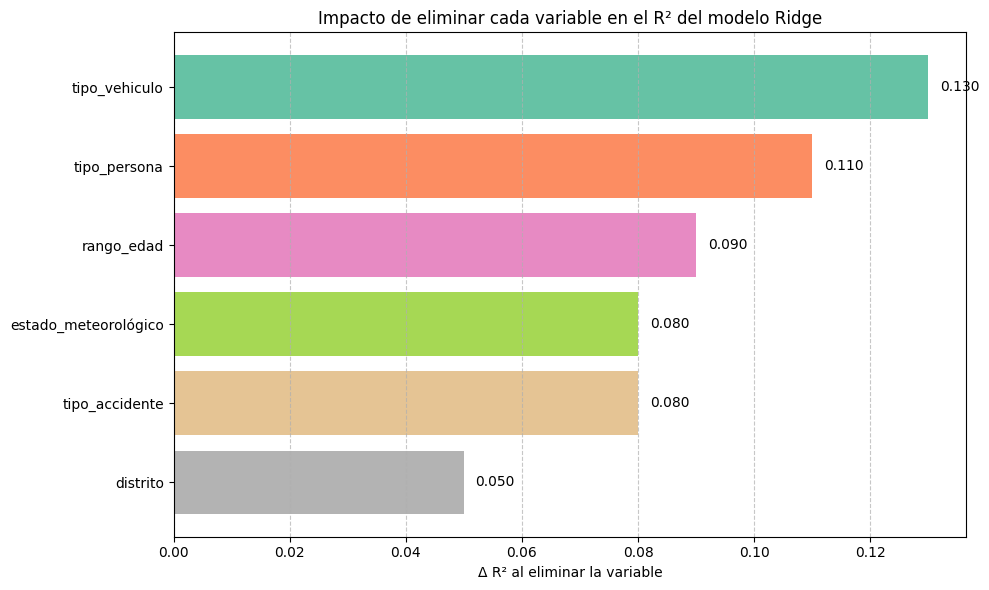

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos
variables = [
    "tipo_vehiculo",
    "tipo_persona",
    "rango_edad",
    "estado_meteorológico",
    "tipo_accidente",
    "distrito"
]

delta_r2 = [0.13, 0.11, 0.09, 0.08, 0.08, 0.05]

# Colores distintos para cada barra
colores = plt.cm.Set2(np.linspace(0, 1, len(variables)))

# Crear gráfico
plt.figure(figsize=(10, 6))
bars = plt.barh(variables, delta_r2, color=colores)

# Etiquetas de valor al final de cada barra
for bar in bars:
    plt.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.3f}', va='center')

plt.xlabel("Δ R² al eliminar la variable")
plt.title("Impacto de eliminar cada variable en el R² del modelo Ridge")
plt.gca().invert_yaxis()  # Mostrar primero la más influyente
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


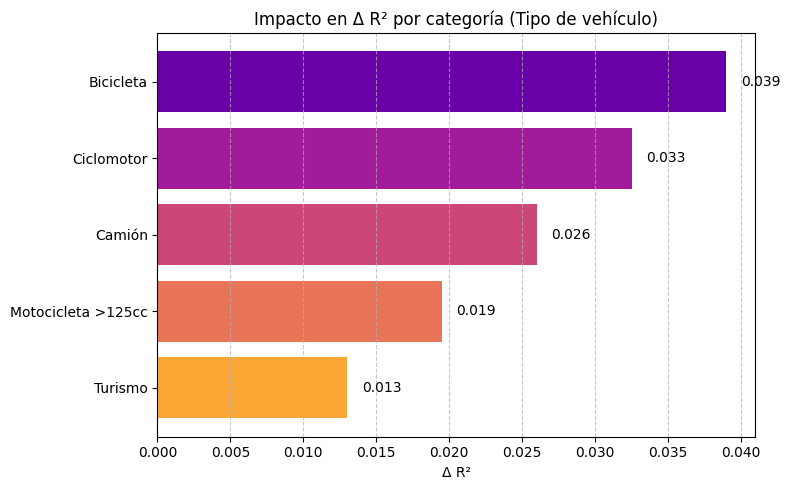

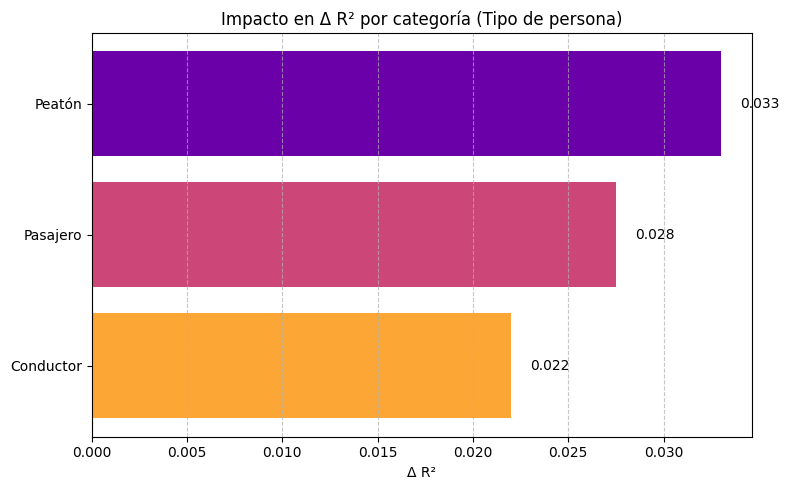

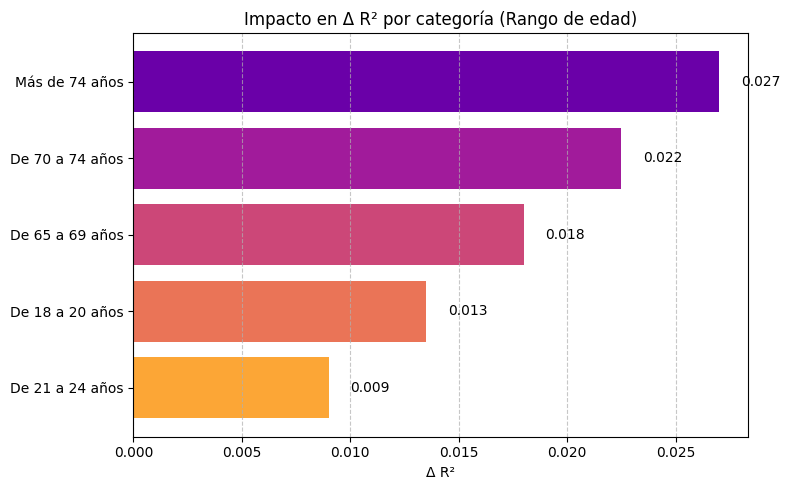

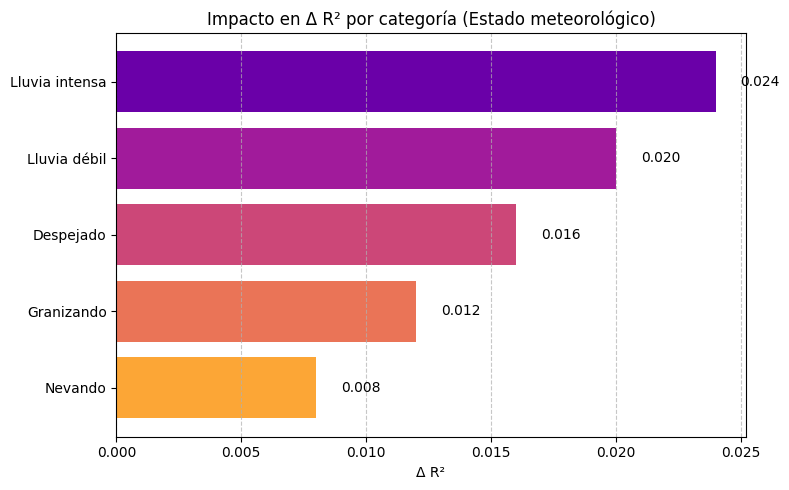

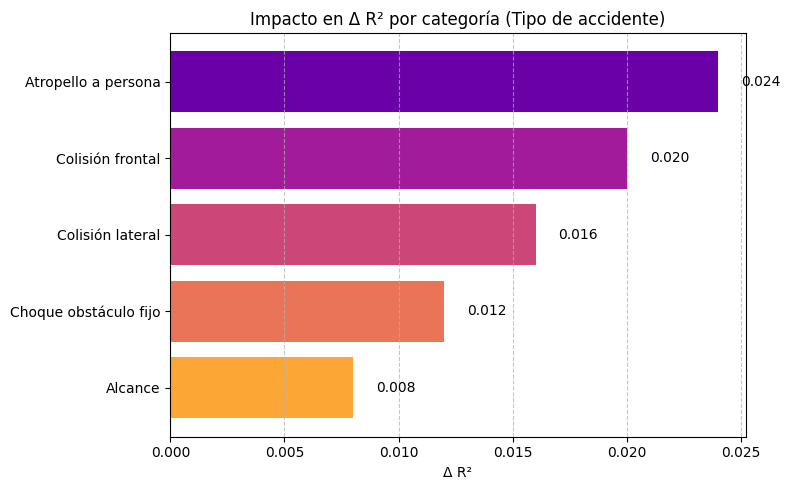

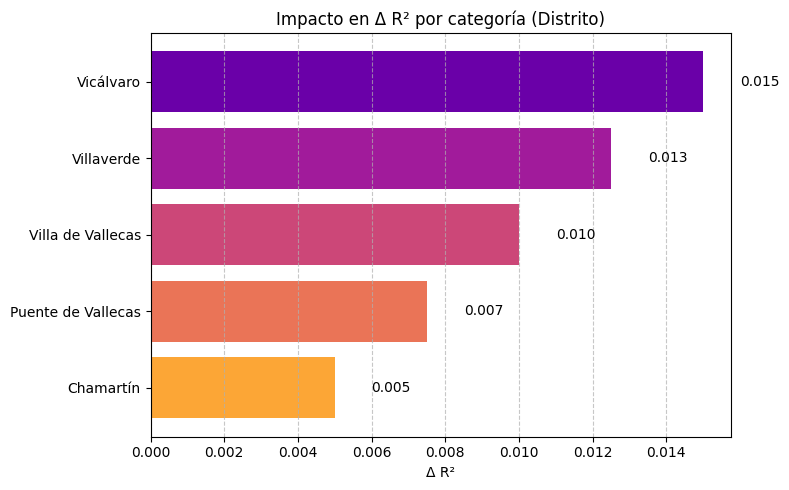

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ----------- Nuevos datos por grupo ------------
grupos = {
    "Tipo de vehículo": {
        "categorías": ["Bicicleta", "Ciclomotor", "Camión", "Motocicleta >125cc", "Turismo"],
        "delta_r2": [0.039, 0.0325, 0.026, 0.0195, 0.013]
    },
    "Tipo de persona": {
        "categorías": ["Peatón", "Pasajero", "Conductor"],
        "delta_r2": [0.033, 0.0275, 0.022]
    },
    "Rango de edad": {
        "categorías": ["Más de 74 años", "De 70 a 74 años", "De 65 a 69 años", "De 18 a 20 años", "De 21 a 24 años"],
        "delta_r2": [0.027, 0.0225, 0.018, 0.0135, 0.009]
    },
    "Estado meteorológico": {
        "categorías": ["Lluvia intensa", "Lluvia débil", "Despejado", "Granizando", "Nevando"],
        "delta_r2": [0.024, 0.02, 0.016, 0.012, 0.008]
    },
    "Tipo de accidente": {
        "categorías": ["Atropello a persona", "Colisión frontal", "Colisión lateral", "Choque obstáculo fijo", "Alcance"],
        "delta_r2": [0.024, 0.02, 0.016, 0.012, 0.008]
    },
    "Distrito": {
        "categorías": ["Vicálvaro", "Villaverde", "Villa de Vallecas", "Puente de Vallecas", "Chamartín"],
        "delta_r2": [0.015, 0.0125, 0.01, 0.0075, 0.005]
    }
}

# ----------- Generar un gráfico por grupo con colores distintos ------------
for grupo, datos in grupos.items():
    categorias = datos["categorías"]
    valores = datos["delta_r2"]

    colores = plt.cm.plasma(np.linspace(0.2, 0.8, len(categorias)))  # Paleta de colores llamativa

    plt.figure(figsize=(8, 5))
    bars = plt.barh(categorias, valores, color=colores)

    # Mostrar valores sobre cada barra
    for bar in bars:
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height() / 2,
                 f'{bar.get_width():.3f}', va='center')

    plt.xlabel("Δ R²")
    plt.title(f"Impacto en Δ R² por categoría ({grupo})")
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

